# FRETBursts - ns-ALEX example

*This notebook is part of a [tutorial series](https://github.com/tritemio/FRETBursts_notebooks) for the [FRETBursts](http://tritemio.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://tritemio.github.io/FRETBursts/)
> workflow for **ns-ALEX smFRET burst analysis**. 

*While FRETBursts does not specifically includes functions for fitting 
TCSPC fluorescence decays, a fitting with exponential decays and 
IRF deconvolution can be easily performed using standard python libraries. 
For an example and a brief discussion see the notebook 
[Lifetime decay fit](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Lifetime_decay_fit.ipynb).*

## Loading FRETBursts

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1101/039198 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

# Downloading the sample data file

The full list of smFRET measurements used in the [FRETBursts tutorials](https://github.com/tritemio/FRETBursts_notebooks) 
can be found on [Figshare](http://dx.doi.org/10.6084/m9.figshare.1456362).

Here we download the ns-ALEX data-file and put it in a folder 
named `data`, inside the notebook folder. 
For this purpose we use the `download_file` function provided 
by FRETBursts:

In [3]:
url = 'http://files.figshare.com/2182602/dsdna_d7_d17_50_50_1.hdf5'

In [4]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182602/dsdna_d7_d17_50_50_1.hdf5
File: dsdna_d7_d17_50_50_1.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/dsdna_d7_d17_50_50_1.hdf5 
Delete it to re-download.


In [5]:
filename = './data/dsdna_d7_d17_50_50_1.hdf5'
filename

'./data/dsdna_d7_d17_50_50_1.hdf5'

## Selecting a data file

Alternatively you can use an open-file dialog in order to select a data file:

In [6]:
# filename = OpenFileDialog()
# filename

In [7]:
import os
if os.path.isfile(filename):
    print("Perfect, I found the file!")
else:
    print("Sorry, I can't find the file:\n%s" % filename)

Perfect, I found the file!


## Load the selected file

Here we load the file and we set the alternation parameters:

In [8]:
d = loader.photon_hdf5(filename)
#d = loader.nsalex(fname)

In [9]:
d.time_max

2268.2743759426116

In [10]:
d.det_t

[array([1, 6, 6, ..., 6, 6, 6], dtype=uint8)]

In [11]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------


       0          1
       1          1
       4    3345380
       6    6371466


In [12]:
#d.add(A_ON=(200, 1500), D_ON=(1750, 3200), det_donor_accept=(4, 6))

In [13]:
d.nanotimes_t

[array([3327,  372,  579, ..., 2553, 1182,  316], dtype=uint16)]

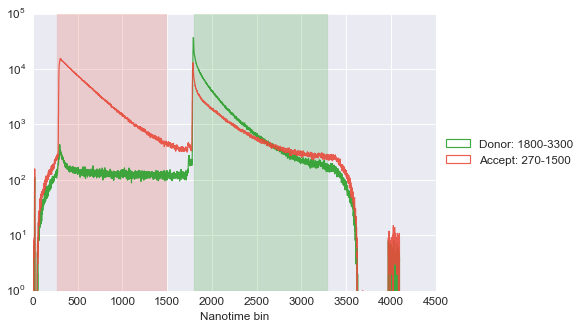

In [14]:
bpl.plot_alternation_hist(d)

Execute the previous 2 cells until you get a satisfying 
selection for the excitation periods. Then run the following 
to apply the parameters:

In [15]:
loader.alex_apply_period(d)

## Burst search and selection

In [16]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


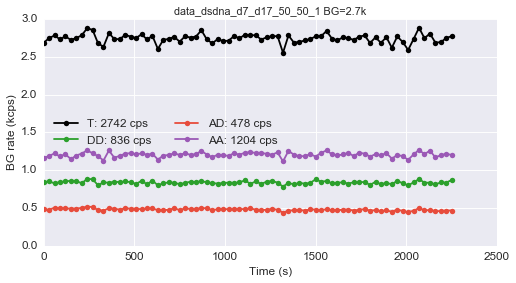

In [17]:
dplot(d, timetrace_bg)

(-50, 50)

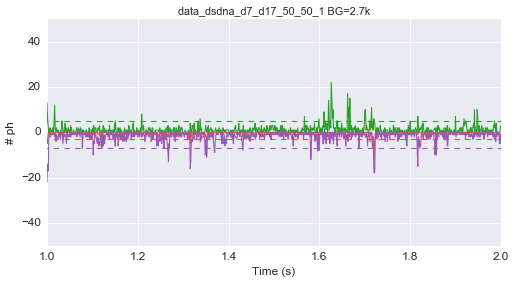

In [18]:
dplot(d, timetrace)
xlim(1, 2)
ylim(-50, 50)

In [19]:
d.burst_search()

 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [20]:
ds = d.select_bursts(select_bursts.size, th1=30)

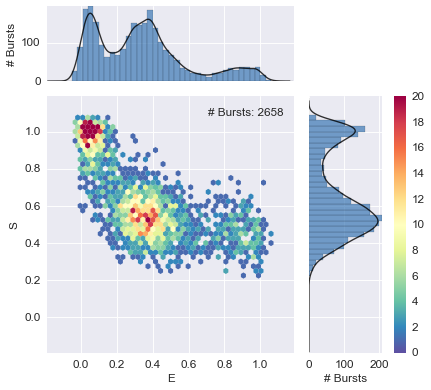

In [21]:
alex_jointplot(ds)

In [22]:
ds.leakage = 0.05

   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


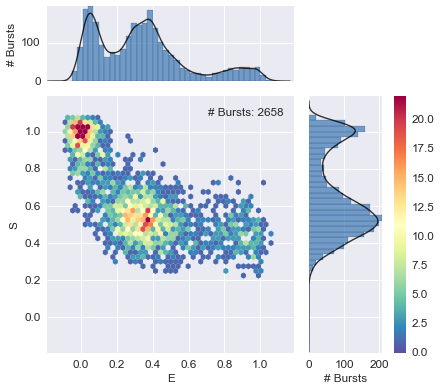

In [23]:
alex_jointplot(ds)

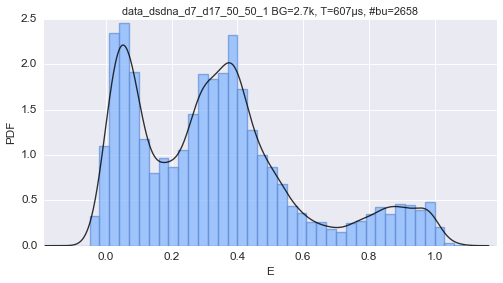

In [24]:
dplot(ds, hist_fret, show_kde=True)

## Nanotimes

The nanotimes for the measurement is saved in the `.nanotimes` 
attribute of the `Data()` object (here either `d` or `ds`).

As an example here we get the array of nanotimes for all photons, 
donor emission and acceptor emission:

In [25]:
d.nanotimes

[array([ 372,  579, 1926, ..., 2553, 1182,  316], dtype=uint16)]

In [26]:
nanotimes = d.nanotimes[0]
nanotimes_d = nanotimes[d.get_D_em()]
nanotimes_a = nanotimes[d.get_A_em()]

We can plot the histogram for this 3 nanotimes:

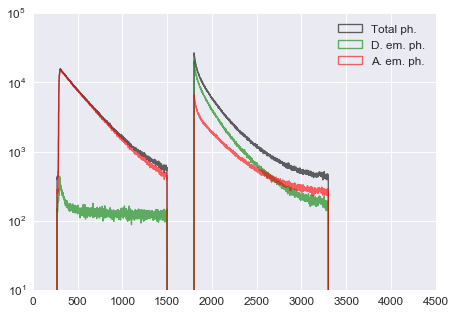

In [27]:
hist_params = dict(bins=range(4096), histtype='step', alpha=0.6, lw=1.5)
hist(nanotimes, color='k', label='Total ph.', **hist_params)
hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

We can also select only nanotimes of photons inside bursts. 
Here, as an example, we will use the `ds` variable that 
contains a selection of bursts.

First we compute a selection mask (a boolean array) for 
photons inside bursts:

In [28]:
ph_in_bursts_mask = d.ph_in_bursts_mask_ich()

Then we apply this selection to the nanotimes array. 
To get the donor- and acceptor-emission nanotimes we combine 
the in-bursts selection mask (`ph_in_bursts_mask`) with 
the donor or acceptor emission mask (that we get with
`.get_D_em()` and `.get_D_em()`):

In [29]:
bursts_nanotimes_t = nanotimes[ph_in_bursts_mask]
bursts_nanotimes_d = nanotimes[ph_in_bursts_mask * d.get_D_em()]
bursts_nanotimes_a = nanotimes[ph_in_bursts_mask * d.get_A_em()]

And, as before, we can histogram the nanotimes:

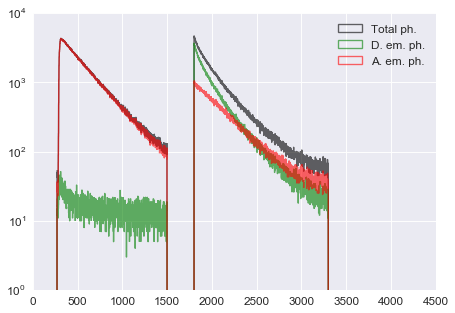

In [30]:
hist_params = dict(bins=range(4096), histtype='step', alpha=0.6, lw=1.5)
hist(bursts_nanotimes_t, color='k', label='Total ph.', **hist_params)
hist(bursts_nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(bursts_nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

## Saving to a file

Saving some of all these arrays to file is straightforward.

### Save array to txt comma-separed-values

To save a single array to a file we can use the [`.tofile`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tofile.html) method:

In [31]:
nanotimes.tofile('nanotimes_t.csv', sep=',\n')  # save in CSV txt format

### Save to legacy MATLAB format

To save a set of arrays in MATLAB format  we can use the 
[`scipy.io.savemat`](http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.io.savemat.html) function.

Here we save 3 arrays `bursts_nanotimes_t`, `bursts_nanotimes_d` 
and `bursts_nanotimes_a` to a file called *bursts_nanotimes.mat*:

In [32]:
from scipy.io import savemat

In [33]:
savemat('bursts_nanotimes.mat', 
        dict(bn_t=bursts_nanotimes_t, 
             bn_d=bursts_nanotimes_d, 
             bn_a=bursts_nanotimes_a,))

When loaded in MATLAB the arrays will be named `bn_t`, `bn_d` and `bn_a`.